In [31]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory  # pip install tf-nightly
from tensorflow.keras.callbacks import ModelCheckpoint

In [32]:
print("Num GPUs Available: ",
      len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [57]:
DATASET_DIR = "./augment_dataset/ms"

TRAIN_DATASET_DIR = DATASET_DIR + '/train'

TEST_DATASET_DIR = DATASET_DIR + '/test'

IMG_SIZE = (32, 32)

BATCH_SIZE = 4

# build train dataset
train_ds = image_dataset_from_directory(directory=TRAIN_DATASET_DIR,
                                        labels='inferred',
                                        label_mode='int',
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE)

#build test dataset
test_ds = image_dataset_from_directory(directory=TEST_DATASET_DIR,
                                       labels='inferred',
                                       label_mode='int',
                                       shuffle=False,
                                       batch_size=BATCH_SIZE,
                                       image_size=IMG_SIZE)

Found 1748 files belonging to 10 classes.
Found 446 files belonging to 10 classes.


train_imgs.shape:  (8, 150, 150, 3)
train_labels.shape:  (8, 10)
['n5_cebus_capucinus_white_headed_capuchin', 'n9_trachypithecus_johnii_nilgiri_langur', 'n3_macaca_fuscata_japanese_macaque', 'n8_aotus_nigriceps_black_headed_night_monkey', 'n7_saimiri_sciureus_common_squirrel_monkey', 'n3_macaca_fuscata_japanese_macaque', 'n0_alouatta_palliata_mantled_howler', 'n1_erythrocebus_patas_patas_monkey']


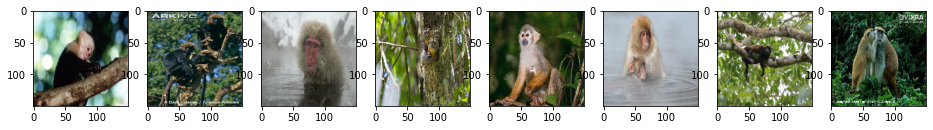

In [34]:
# show train batch
train_imgs, train_labels = next(iter(train_ds))

print("train_imgs.shape: ", train_imgs.shape)
print("train_labels.shape: ", train_labels.shape)

plt.figure(num=BATCH_SIZE, figsize=(16, 16))
for i, img in enumerate(train_imgs):
    plt.subplot(1, BATCH_SIZE, i + 1)
    plt.imshow(tf.make_ndarray(tf.make_tensor_proto(img)).astype('uint8'))

labels = [
    train_ds.class_names[np.where(label == 1)[0][0]] for label in train_labels
]
print(labels)

In [35]:
# show dataset info
print("\ntraing dataset size:", len(train_ds))
print("test dataset size:", len(test_ds))
print("\nclass names:\n", train_ds.class_names)


traing dataset size: 219
test dataset size: 56

class names:
 ['n0_alouatta_palliata_mantled_howler', 'n1_erythrocebus_patas_patas_monkey', 'n2_cacajao_calvus_bald_uakari', 'n3_macaca_fuscata_japanese_macaque', 'n4_cebuella_pygmea_pygmy_marmoset', 'n5_cebus_capucinus_white_headed_capuchin', 'n6_mico_argentatus_silvery_marmoset', 'n7_saimiri_sciureus_common_squirrel_monkey', 'n8_aotus_nigriceps_black_headed_night_monkey', 'n9_trachypithecus_johnii_nilgiri_langur']


In [60]:
class SE_Block(Model):
    def __init__(self, filters):
        super(SE_Block, self).__init__(name='')

        r = 8

        self.global_avg_pool = GlobalAveragePooling2D()

        self.fc1 = Dense(filters / r, activation='relu')

        self.fc2 = Dense(filters, activation='sigmoid')

    def call(self, x):
        c = x.shape[-1]
        inp = x
        x = self.global_avg_pool(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = tf.reshape(x, [-1, 1, 1, c])
        x *= inp

        return x

In [39]:
class ResBasicBlock(Model):
    def __init__(self, filters, kernel_size, padding='same', strides=1):
        super(ResBasicBlock, self).__init__(name='')

        flt1, flt2, flt3 = filters

        self.conv1 = Conv2D(flt1, 1, padding=padding, strides=strides)
        #             kernel_regularizer=tf.keras.regularizers.l2(l=0.003))

        self.covn2 = Conv2D(flt2, kernel_size, padding=padding)

        self.conv3 = Conv2D(flt3, 1, padding=padding)
        #             kernel_regularizer=tf.keras.regularizers.l2(l=0.003))

        self.reshape_conv = Conv2D(flt3, 1, padding=padding, strides=strides)

        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()
        self.bn3 = BatchNormalization()
        self.bn4 = BatchNormalization()

    def call(self, x):
        inp = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = tf.nn.relu(x)

        x = self.covn2(x)
        x = self.bn2(x)
        x = tf.nn.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        inp = self.reshape_conv(inp)
        inp = self.bn4(inp)
        x += inp

        x = tf.nn.relu(x)

        return x

In [61]:
class WatashiNet(Model):
    def __init__(self):
        super(WatashiNet, self).__init__(name='WatashiNet')
        self.conv1 = Conv2D(32, (3, 3), activation='relu')
        self.max_pool1 = MaxPooling2D((2, 2))
        
        self.conv2 = ResBasicBlock((32,64,64), 3)
        self.se2 = SE_Block(64)
        self.max_pool2 = MaxPooling2D((2, 2))
        
        self.conv3 = ResBasicBlock((64,64,128), 3)
        self.se3 = SE_Block(128)
        
        self.conv4 = ResBasicBlock((64,64,128), 3)
        self.se4 = SE_Block(128)
        
        self.pool3 = AveragePooling2D((1, 1))
        self.drop1 = Dropout(0.25)

        self.flatten = Flatten()
        self.drop2 = Dropout(0.5)
        self.fc2 = Dense(10, activation='softmax')

    def call(self, x):
        x = x / 255.0  # normalization
        
        x = self.conv1(x)
        x = self.max_pool1(x)
        
        x = self.conv2(x)
        x = self.se2(x)
        x = tf.nn.relu(x)
        x = self.max_pool2(x)
        
        x = self.conv3(x)
        x = self.se3(x)
        x = tf.nn.relu(x)
        
        x = self.conv4(x)
        x = self.se4(x)
        x = tf.nn.relu(x)
        
        x = self.pool3(x)
        x = self.drop1(x)
        
        x = self.flatten(x)
        x = self.drop2(x)
        x = self.fc2(x)

        return x

In [62]:
imgs, _ = next(iter(train_ds))

model = WatashiNet()

model.build(imgs.shape)

model.summary()

Model: "WatashiNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_116 (Conv2D)          multiple                  896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling multiple                  0         
_________________________________________________________________
res_basic_block_24 (ResBasic multiple                  26720     
_________________________________________________________________
se__block (SE_Block)         multiple                  1096      
_________________________________________________________________
max_pooling2d_26 (MaxPooling multiple                  0         
_________________________________________________________________
res_basic_block_25 (ResBasic multiple                  59264     
_________________________________________________________________
se__block_1 (SE_Block)       multiple                  4

In [66]:
EPOCHS = 1

checkpoint_path = "checkpoint/ms/cp.ckpt"

cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              save_best_only=True,
                              mode='min',
                              verbose=1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_ds,
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=len(train_ds),
                    validation_data=test_ds,
                    validation_steps=len(test_ds),
                    epochs=EPOCHS,
                    callbacks=[cp_callback])

437/437 [==============================] - ETA: 0s - loss: 0.0086 - acc: 0.9971
Epoch 00001: val_loss improved from inf to 2.08056, saving model to checkpoint/ms\cp.ckpt
437/437 [==============================] - 22s 49ms/step - loss: 0.0086 - acc: 0.9971 - val_loss: 2.0806 - val_acc: 0.7108


In [69]:
loss, acc = model.evaluate(test_ds,
                    batch_size=BATCH_SIZE,
                    steps=len(test_ds))
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

112/112 [==============================] - 3s 28ms/step - loss: 2.0806 - acc: 0.7108
Restored model, accuracy: 71.08%
